In [2]:
!pip install gdown

In [3]:
import gdown
gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd
From (redirected): https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd&confirm=t&uuid=6582ac62-4e55-42f9-806e-75419930487b
To: /aiffel/aiffel/Untitled Folder/dogs-vs-cats.zip
100%|██████████| 852M/852M [00:05<00:00, 160MB/s]  


'dogs-vs-cats.zip'

In [4]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [5]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

In [8]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [10]:
for data_batch, labels_batch in train_dataset:
    print("데이터 배치 크기:", data_batch.shape)
    print("레이블 배치 크기:", labels_batch.shape)
    break

데이터 배치 크기: (32, 180, 180, 3)
레이블 배치 크기: (32,)


In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 54s 63ms/step - loss: 0.7304 - accuracy: 0.5215 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 3s 47ms/step - loss: 0.6958 - accuracy: 0.5235 - val_loss: 0.6888 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 3s 48ms/step - loss: 0.6906 - accuracy: 0.5575 - val_loss: 0.6676 - val_accuracy: 0.5720
Epoch 4/30
63/63 [==============================] - 3s 48ms/step - loss: 0.6779 - accuracy: 0.5840 - val_loss: 0.6447 - val_accuracy: 0.6360
Epoch 5/30
63/63 [==============================] - 3s 47ms/step - loss: 0.6695 - accuracy: 0.6405 - val_loss: 0.6623 - val_accuracy: 0.6380
Epoch 6/30
63/63 [==============================] - 3s 47ms/step - loss: 0.6023 - accuracy: 0.6815 - val_loss: 0.6248 - val_accuracy: 0.6580
Epoch 7/30
63/63 [==============================] - 3s 47ms/step - loss: 0.5701 - accuracy: 0.7105 - val_loss: 0.6120 - val_accuracy: 0.6630
Epoch 8/30
6

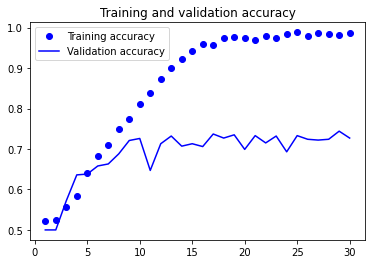

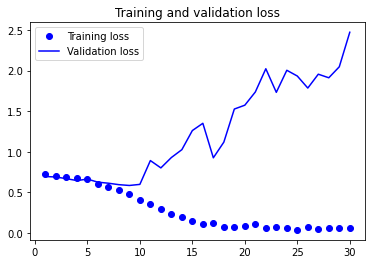

In [12]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [13]:
test_model = keras.models.load_model("convnet_from_scratch.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 2s 20ms/step - loss: 0.6146 - accuracy: 0.7065
테스트 정확도: 0.706


In [14]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

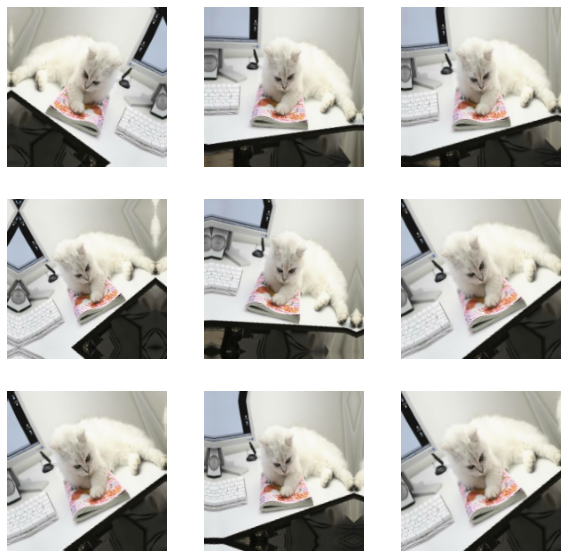

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [16]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 5s 58ms/step - loss: 0.7759 - accuracy: 0.5210 - val_loss: 0.6828 - val_accuracy: 0.5850
Epoch 2/100
63/63 [==============================] - 4s 56ms/step - loss: 0.6876 - accuracy: 0.5585 - val_loss: 0.6647 - val_accuracy: 0.5850
Epoch 3/100
63/63 [==============================] - 4s 55ms/step - loss: 0.6969 - accuracy: 0.5820 - val_loss: 0.6604 - val_accuracy: 0.5770
Epoch 4/100
63/63 [==============================] - 4s 55ms/step - loss: 0.6577 - accuracy: 0.6255 - val_loss: 0.6359 - val_accuracy: 0.6350
Epoch 5/100
63/63 [==============================] - 4s 55ms/step - loss: 0.6536 - accuracy: 0.6310 - val_loss: 0.6483 - val_accuracy: 0.6050
Epoch 6/100
63/63 [==============================] - 4s 55ms/step - loss: 0.6326 - accuracy: 0.6455 - val_loss: 0.6019 - val_accuracy: 0.6580
Epoch 7/100
63/63 [==============================] - 4s 55ms/step - loss: 0.6257 - accuracy: 0.6480 - val_loss: 0.6156 - val_accuracy: 0.6380
Epoch 